In [22]:
import pandas as pd
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from razdel import sentenize, tokenize
from nltk.corpus import stopwords
import stanza
import numpy as np

In [25]:
import pandas as pd
import re
import stanza
from razdel import sentenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

data_opinion = pd.read_json("data_cleaned_opinion.json")

analyzer = SentimentIntensityAnalyzer()
stanza.download('ru')
stanza_nlp = stanza.Pipeline('ru', processors='tokenize,lemma', use_gpu=False)
stop_words = set(stopwords.words("russian"))

def extract_zelensky_sentences(text):
    return [s.text for s in sentenize(text) if re.search(r"зеленск", s.text, flags=re.IGNORECASE)]

def normalize(text):
    doc = stanza_nlp(text.lower())
    return " ".join([
        word.lemma for sent in doc.sentences for word in sent.words
        if word.lemma.isalpha() and word.lemma not in stop_words
    ])

def get_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

data_opinion['zelensky_sentences'] = data_opinion['full_text'].apply(extract_zelensky_sentences)
df_zelensky = data_opinion.explode('zelensky_sentences').dropna(subset=['zelensky_sentences'])
df_zelensky['normalized'] = df_zelensky['zelensky_sentences'].apply(normalize)
df_zelensky['vader_score'] = df_zelensky['normalized'].apply(get_sentiment)

def classify(score):
    if score >= 0.01:
        return 'positive'
    elif score <= -0.01:
        return 'negative'
    else:
        return 'neutral'

df_zelensky['vader_label'] = df_zelensky['vader_score'].apply(classify)

2025-06-05 23:59:26 INFO: Downloaded file to C:\Users\Andraf\stanza_resources\resources.json
2025-06-05 23:59:26 INFO: Downloading default packages for language: ru (Russian) ...
2025-06-05 23:59:27 INFO: File exists: C:\Users\Andraf\stanza_resources\ru\default.zip
2025-06-05 23:59:34 INFO: Finished downloading models and saved to C:\Users\Andraf\stanza_resources
2025-06-05 23:59:34 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-06-05 23:59:34 INFO: Downloaded file to C:\Users\Andraf\stanza_resources\resources.json
2025-06-05 23:59:34 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| lemma     | syntagrus_nocharlm |

2025-06-05 23:59:34 INFO: Using device: cpu
2025-06-05 23:59:34 INFO: Loading: tokenize
2025-06-05 23:59:34 INFO: Loading: lemma
2025-06-05 23:59:36 INFO: Done loading processors!


In [26]:
df_zelensky['vader_label'].describe()

count        9131
unique          3
top       neutral
freq         9127
Name: vader_label, dtype: object

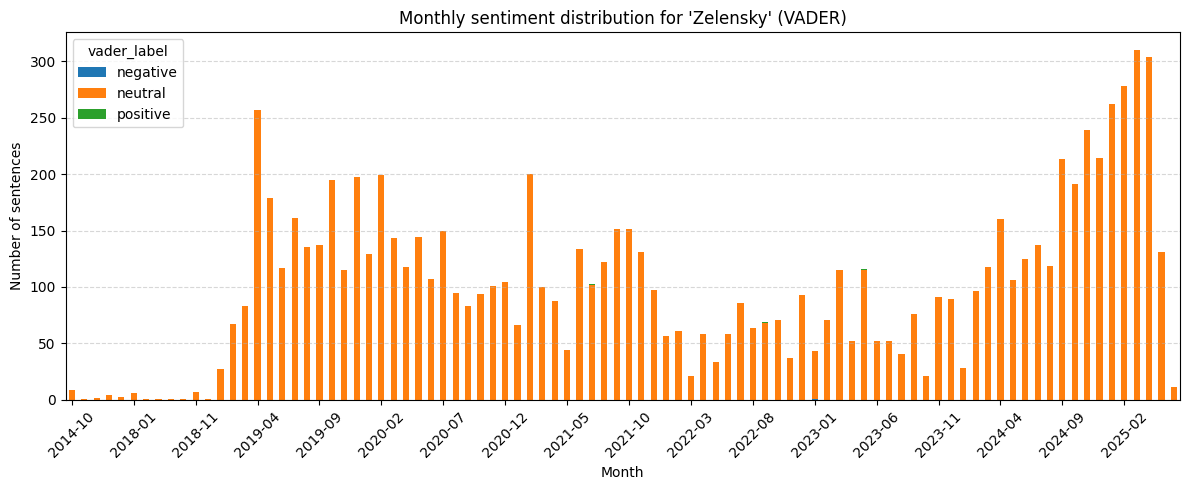

In [27]:
df_zelensky['date'] = pd.to_datetime(df_zelensky['date_parsed'], errors='coerce')
df_zelensky = df_zelensky.dropna(subset=['date'])

# Regrouper par mois + sentiment
df_zelensky['year_month'] = df_zelensky['date'].dt.to_period('M').astype(str)
monthly = df_zelensky.groupby(['year_month', 'vader_label']).size().reset_index(name='count')
pivoted = monthly.pivot_table(index='year_month', columns='vader_label', values='count', fill_value=0)

# Affichage
pivoted.plot(kind='bar', stacked=True, figsize=(12, 5))

xticks_idx = np.arange(0, len(pivoted.index), 5)
plt.xticks(ticks=xticks_idx, labels=pivoted.index[xticks_idx], rotation=45)

plt.title("Monthly sentiment distribution for 'Zelensky' (VADER)")
plt.xlabel("Month")
plt.ylabel("Number of sentences")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()